In [1]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys
import matplotlib.pyplot as plt

In [2]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=100)
    #print(total_cost_new)
    return total_cost_new, wall_cost, n_cost_direct_sum_div

def objective3(x_input, numiter = 100):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost, n_cost_direct_sum_div = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=numiter)
    return total_cost_new, wall_cost, n_cost_direct_sum_div

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]





C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
testwall = np.array([2.16666667,1.33333333,2.16666667,0.16666667,0.83333333,1.0,2.0,1.16666667])

In [4]:
total_cost_new, wall_cost, n_cost_direct_sum_div = objective2(testwall)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
print(total_cost_new)
print(wall_cost)

2320020819.6121426
985060200.7053719


In [5]:
div_array = np.array(n_cost_direct_sum_div)
print(div_array.shape)

(100, 18, 1)


In [10]:
np.save('wall8partsdivarray.npy',div_array.reshape((100,18)))

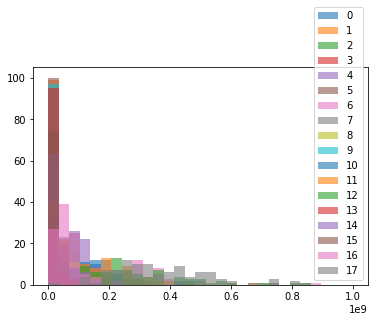

In [9]:
bins = np.linspace(0,1e9,30)
for i in range(18):
    plt.hist(div_array[:,i,0],bins = bins, alpha = 0.6, label = str(i))
plt.legend()

In [34]:
print(total_cost_new/1e9)

2.3200208196121426


In [30]:
div_array = np.array(n_cost_direct_sum_div)
B = 1e9

In [31]:
if np.sum(np.sum(div_array[:,:,0] < B, axis = 0) > 95) == 18:
    print('satisfy')
print(np.sum(div_array[:,:,0] < B, axis = 0) > 95)

satisfy
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
